# Importign required modules

In [29]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [30]:
# Train transformations
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])

# Test transformations
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  ])


In [31]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [32]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Stats
Calculating the mean and standard deviation of the data.

Just for understanding the data.

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train data]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


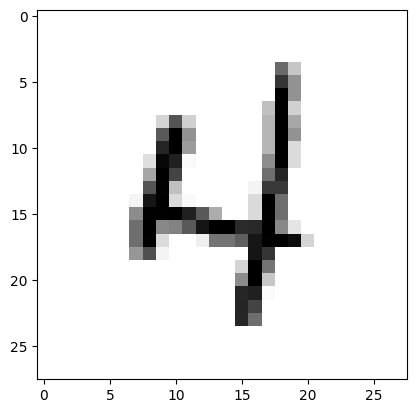

In [33]:
# Convert back tensors back to Numpy
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train data]')
print(' - Numpy Shape:', train_data.numpy().shape)
print(' - Tensor Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

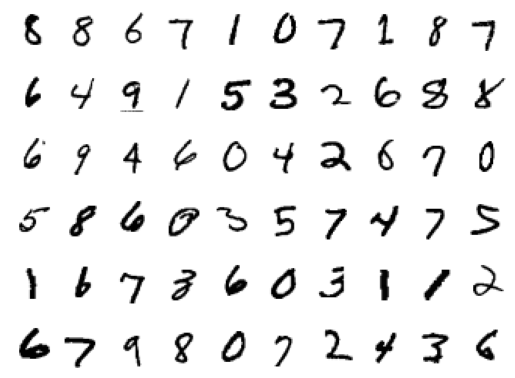

In [34]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Data Stats2
The previous block provided statistics for a normalized dataset, resulting in a mean of zero and a standard deviation of one. In this block, we obtain the mean and standard deviation for the raw, unnormalized data.

This step is not necessary if we already have prior knowledge of the mean and standard deviation of the dataset

In [35]:
# simple transform
simple_transforms = transforms.Compose([transforms.ToTensor(),])

exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp_data.numpy().shape)
print(' - Tensor Shape:', exp_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (28, 60000, 28)
 - Tensor Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Model

In [47]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24


        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [48]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [49]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [51]:
# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.05076831206679344 Batch_id=468 Accuracy=87.78: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]



Test set: Average loss: 0.0709, Accuracy: 9818/10000 (98.18%)

EPOCH: 1


Loss=0.12874455749988556 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]



Test set: Average loss: 0.0493, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.04081844538450241 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]



Test set: Average loss: 0.0381, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


Loss=0.04897594824433327 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]



Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.04041024297475815 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]



Test set: Average loss: 0.0286, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.09355916827917099 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]



Test set: Average loss: 0.0307, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.005360402166843414 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 21.83it/s]



Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.015012751333415508 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]



Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.013654245994985104 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:20<00:00, 23.45it/s]



Test set: Average loss: 0.0275, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.013476669788360596 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]



Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.015177561901509762 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]



Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.0398046039044857 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 23.57it/s]



Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.009413686580955982 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]



Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.022727688774466515 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]



Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.010985211469233036 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]



Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.0021529558580368757 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]



Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.007459984626621008 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]



Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.03549845144152641 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]



Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.003866359358653426 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]



Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

EPOCH: 19


Loss=0.02653493732213974 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]



Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)



# Plot the Results

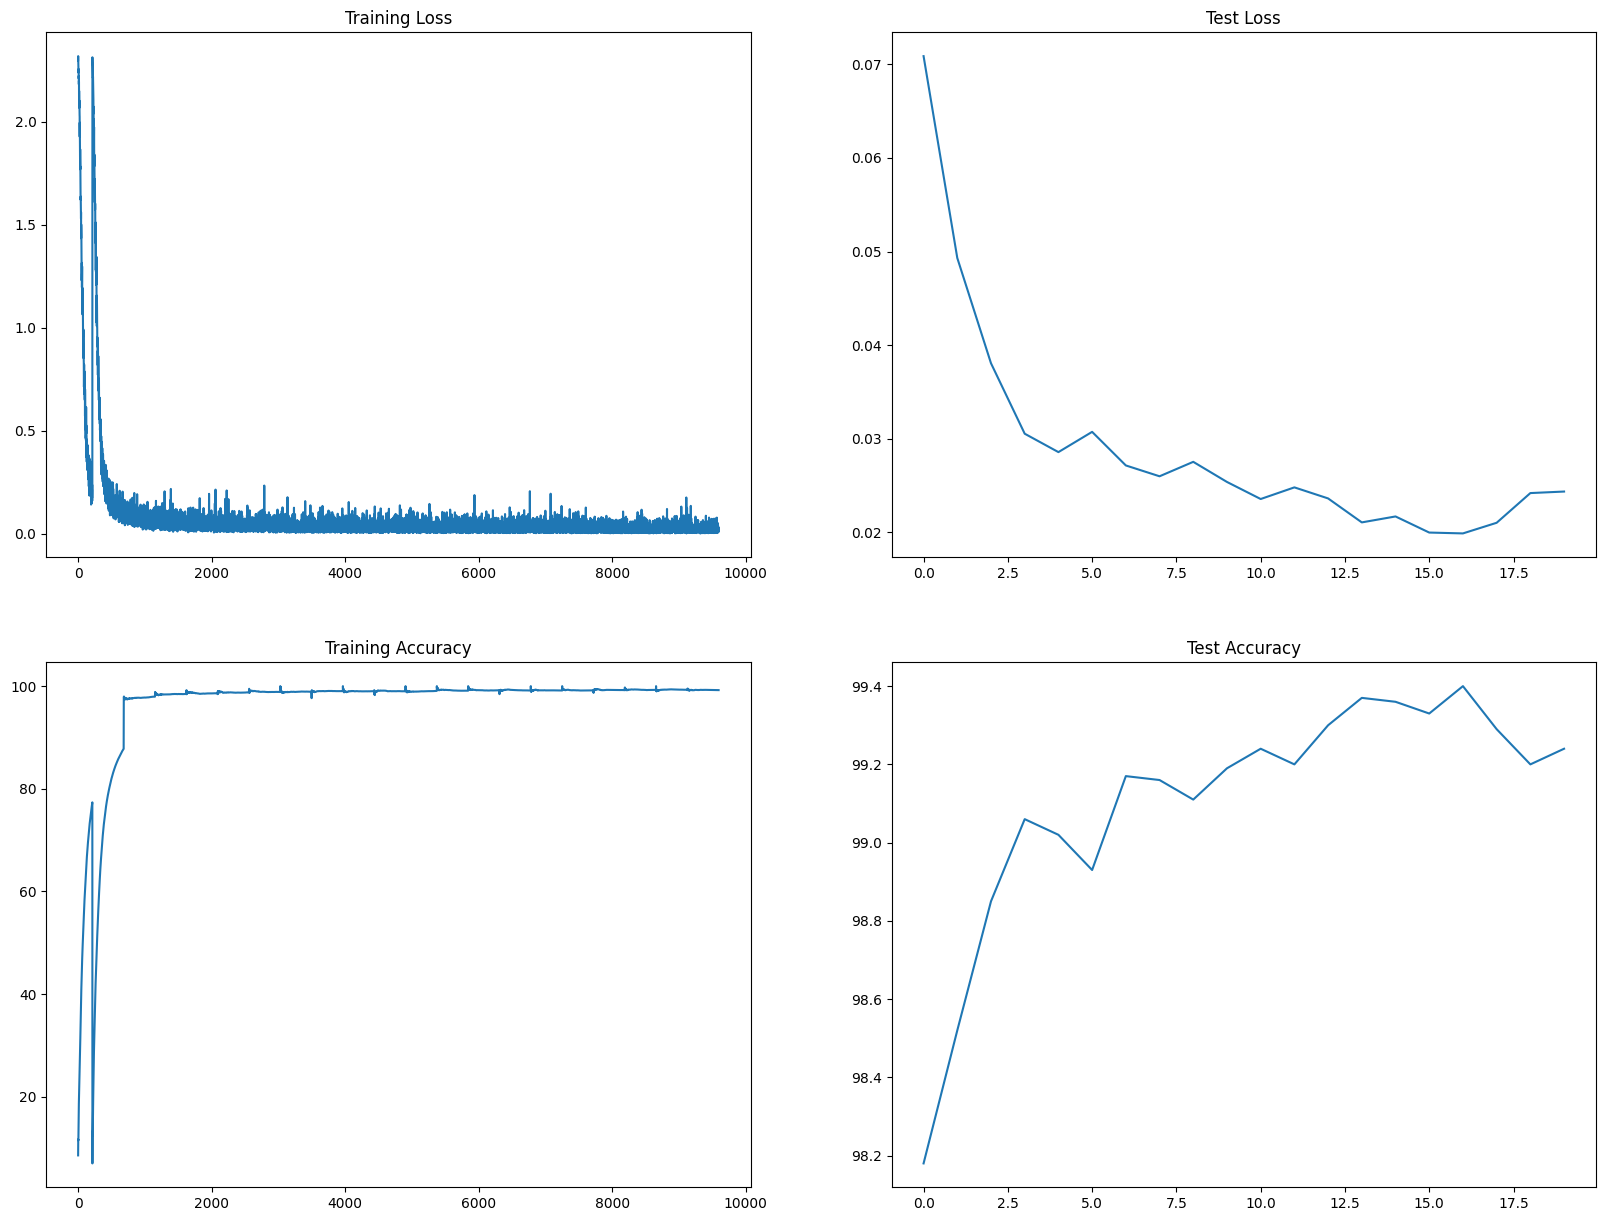

In [52]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(20,15))

axs[0, 0].set_title("Training Loss")
axs[0, 0].plot(t)

axs[1, 0].set_title("Training Accuracy")
axs[1, 0].plot(train_acc)

axs[0, 1].set_title("Test Loss")
axs[0, 1].plot(test_losses)

axs[1, 1].set_title("Test Accuracy")
axs[1, 1].plot(test_acc)

# Iteration 8
---
##Target:
*   Added dropouts after each layer, except for the transition block and the last layer.
*   Included MaxPooling after achieving an RF (Receptive Field) of 5.
*   Increased the model capacity throughout the layers. Additionally, appended a new layer after the Global Average Pooling (GAP) layer.

##Results:
*   Total params: 13,808
*   Best Training Accuracy: 99.29%
*   Best Test Accuracy: 98.40%

##Analysis:
*   There is a slight underfitting issue due to the presence of dropout layers.
*   Although the targeted test accuracy has been achieved, it is not consistently maintained.
